## Operator Overloading 101
* We cannot overload operators for the built-in types.
* We cannot create new operators, only overload existing ones.
* A few operators can’t be overloaded: is, and, or, not (but the bitwise &, |, ~, can).

## Unary Operators
* (\_\_neg\_\_) -

Arithmetic unary negation. If x is -2 then -x == 2.

* (\_\_pos\_\_) +

Arithmetic unary plus. Usually x == +x, but there are a few cases when that’s not true.

* (\_\_invert\_\_) ~

Bitwise inverse of an integer, defined as ~x == -(x+1). If x is 2 then ~x == -3.

In [1]:
from vector import Vector
import decimal
from collections import Counter
from fractions import Fraction

## When x and +x Are Not Equal
Everybody expects that x == +x, and that is true almost all the time in Python, but I found two cases in the standard library where x != +x.

The first case involves the `decimal.Decimal` class.

In [2]:
ctx = decimal.getcontext()
ctx.prec = 40  # Precision
one_third = decimal.Decimal('1') / decimal.Decimal('3')
one_third

Decimal('0.3333333333333333333333333333333333333333')

In [3]:
one_third == +one_third

True

In [4]:
ctx.prec = 28
one_third == +one_third 

False

In [5]:
+one_third

Decimal('0.3333333333333333333333333333')

The second case where x != +x you can find in the `collections.Counter`. The Counter class implements several arithmetic operators, including infix + to
add the tallies from two Counter instances. However, for practical reasons, Counter addition discards from the result any item with a negative or zero count. And the prefix + is a shortcut for adding an empty Counter, therefore it produces a new Counter preserving only the tallies that are greater than zero.

In [6]:
ct = Counter('abracadabra')
ct

Counter({'a': 5, 'b': 2, 'r': 2, 'c': 1, 'd': 1})

In [7]:
ct['r'] = -3

In [8]:
ct['d'] = 0

In [9]:
ct

Counter({'a': 5, 'b': 2, 'r': -3, 'c': 1, 'd': 0})

In [10]:
+ct

Counter({'a': 5, 'b': 2, 'c': 1})

In [11]:
ct == +ct

False

## Overloading + for Vector Addition

In [12]:
def __add__(self, other):
    if isinstance(other, Vector):
        pairs = itertools.zip_longest(self, other, fillvalue=0.0)
        return Vector(a + b for a, b in pairs)
    else:
        raise TypeError("Vector is incompatible with type(other).__name__")

In [13]:
v1 = Vector([3, 4, 5])
v2 = Vector([6, 7, 8])
v1 + v2

Vector([9.0, 11.0, 13.0])

In [14]:
v1 + v2 == Vector([3+6, 4+7, 5+8])

True

In [15]:
v1 = Vector([3, 4, 5, 6])
v3 = Vector([1, 2])
v1 + v3

Vector([4.0, 6.0, 5.0, 6.0])

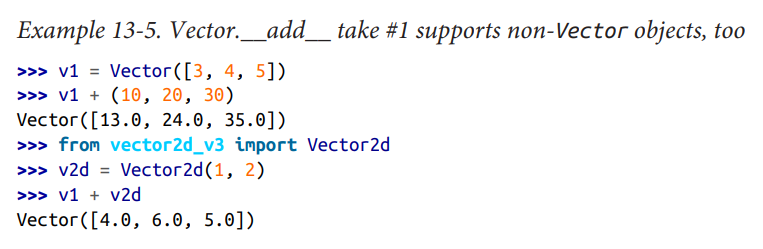

Both additions in Example 13-5 work because `__add__` uses `zip_longest(…)`, which can consume any iterable, and the generator expression to build the new Vector merely performs a + b with the pairs produced by `zip_longest(…)`, so an iterable producing any number items will do.

However, if we swap the operands, the mixed-type additions fail.

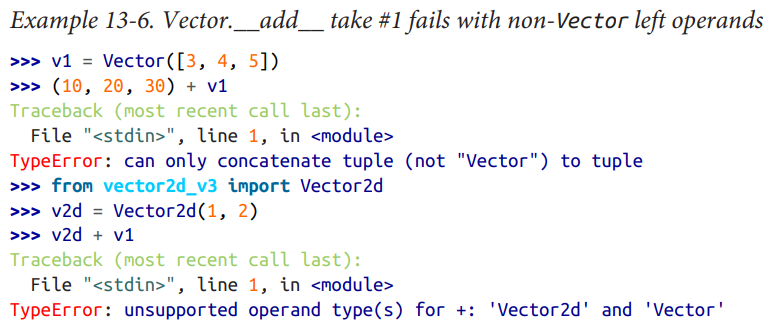

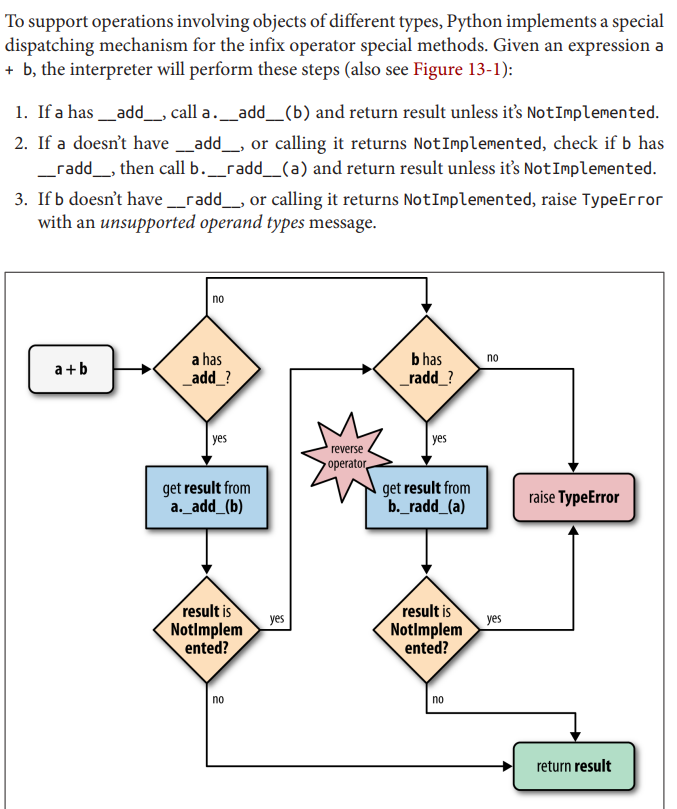

In [16]:
def __radd__(self, other): # Inside the Vector class
    return self + other

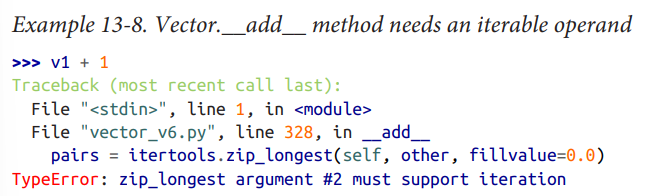
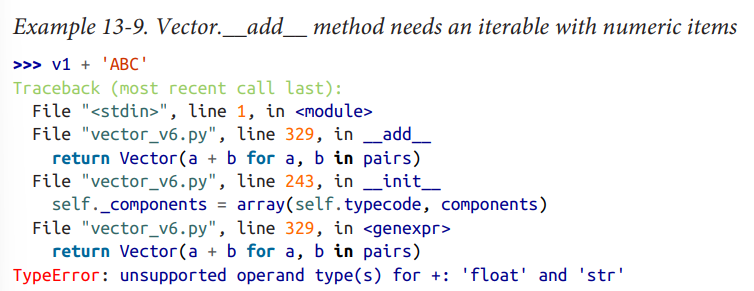

If an operator special method cannot return a valid result because of type incompatibility, it should return `NotImplemented` and not raise `TypeError`.

In [17]:
def __add__(self, other):
    try:
        pairs = itertools.zip_longest(self, other, fillvalue=0.0)
        return Vector(a + b for a, b in pairs)
    except TypeError:
        return NotImplemented

def __radd__(self, other):
    return self + other

## Overloading * for Scalar Multiplication

In [18]:
def __mul__(self, scalar):
    return Vector(n * scalar for n in self)

In [19]:
v1 = Vector([1, 2, 3])
v1 * 10

Vector([10.0, 20.0, 30.0])

In [20]:
11 * v1

Vector([11.0, 22.0, 33.0])

Another kind of product involving Vector operands would be the dot product of two vectors—or matrix multiplication, if you take one vector as a 1 × N matrix and the other as an N × 1 matrix. The current practice in NumPy and similar libraries is not to overload the * with these two meanings, but to use * only for the scalar product. For example, in NumPy, numpy.dot() computes the dot product.

Those methods do work, except when provided with incompatible operands. The
scalar argument has to be a number that when multiplied by a float produces another float (because our Vector class uses an array of floats internally). So a complex number will not do, but the scalar can be an int, a bool (because bool is a subclass of int), or even a fractions.Fraction instance.

We use isinstance() to check the type of scalar, but instead of hardcoding some concrete types, we check against the numbers.Real ABC, which covers all the types we need, and keeps our implementation open to future numeric types that declare themselves actual or virtual subclasses of the numbers.Real ABC.

In [21]:
def __mul__(self, scalar):
    if isinstance(scalar, numbers.Real): # 
        return Vector(n * scalar for n in self)
    else: # 
        return NotImplemented

In [22]:
14 * v1

Vector([14.0, 28.0, 42.0])

In [23]:
v1 * True

Vector([1.0, 2.0, 3.0])

In [24]:
v1 * Fraction(1, 3)

Vector([0.3333333333333333, 0.6666666666666666, 1.0])

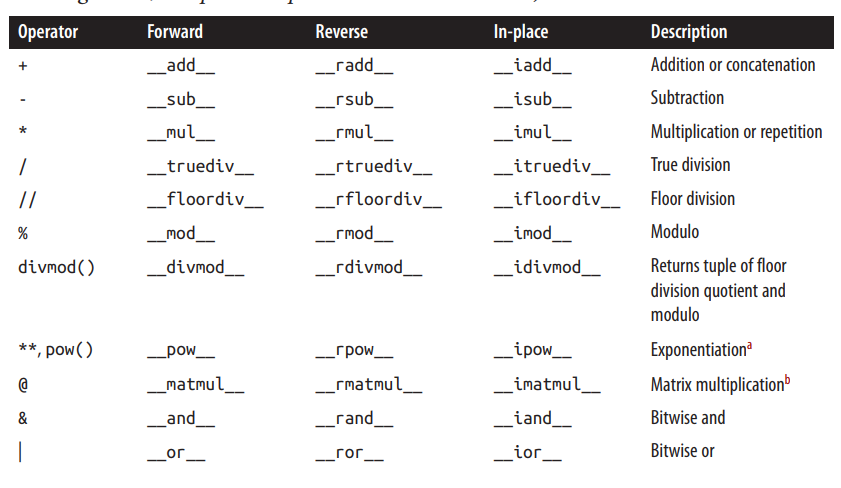
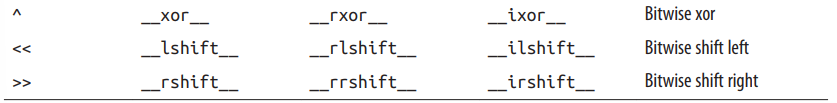

## The New @ Infix Operator
The @ operator is supported by the special methods __mat
mul__, __rmatmul__, and __imatmul__, named for “matrix multiplication.” These methods are not used anywhere in the standard library at this time, but are recognized by the interpreter in Python 3.5 so the NumPy team—and the rest of us—can support the @ operator in user-defined types. The parser was also changed to handle the infix @.

In [25]:
def __matmul__(self, other):
    try:
        return sum(a * b for a, b in zip(self, other))
    except TypeError:
        return NotImplemented

def __rmatmul__(self, other):
    return self @ other

In [26]:
va = Vector([1, 2, 3])
vz = Vector([5, 6, 7])
va @ vz == 38.0 # 1*5 + 2*6 + 3*7

True

In [27]:
[10, 20, 30] @ vz

380.0

In [28]:
try:
    va @ 3
except TypeError:
    pass

## Rich Comparison Operators
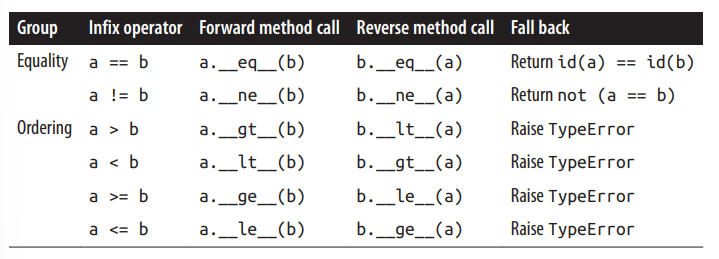
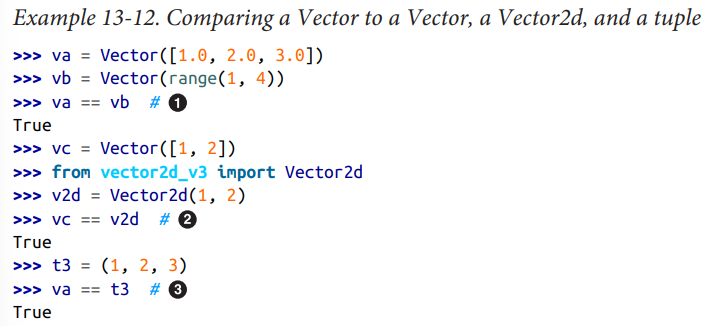

In [29]:
def __eq__(self, other):
    if isinstance(other, Vector): 
        return (len(self) == len(other) and
                all(a == b for a, b in zip(self, other)))
    else:
        return NotImplemented

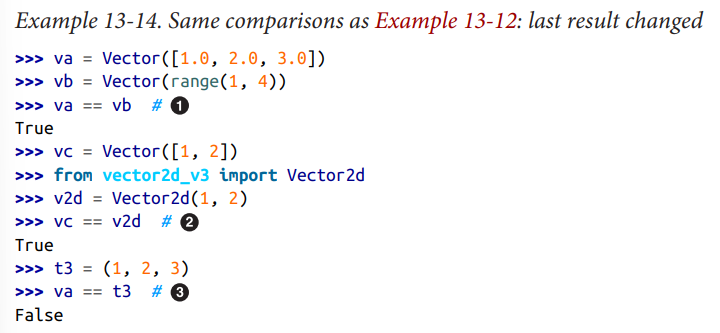
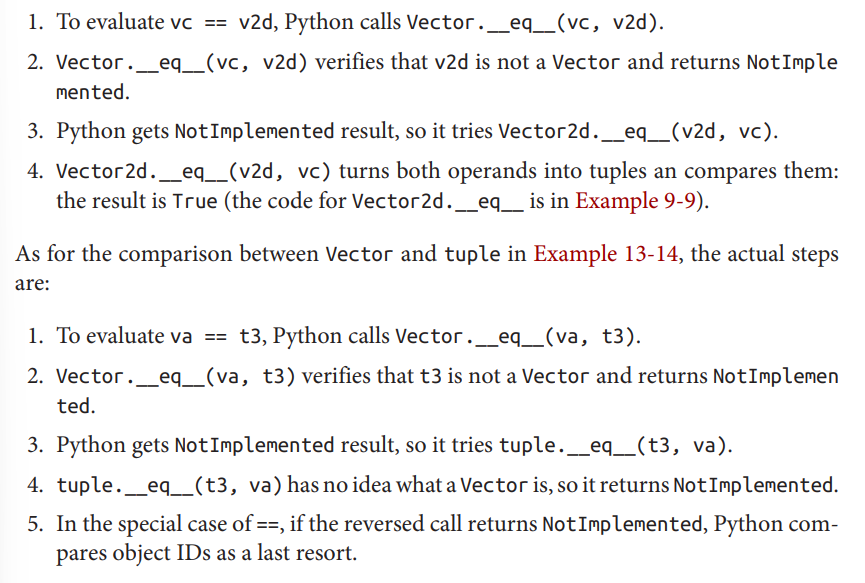

In [30]:
# The __ne__ inherited from object works like the following code—except that the orig‐
# inal is written in C:
def __ne__(self, other):
    eq_result = self == other
    if eq_result is NotImplemented:
        return NotImplemented
    else:
        return not eq_result

## Augmented Assignment Operators
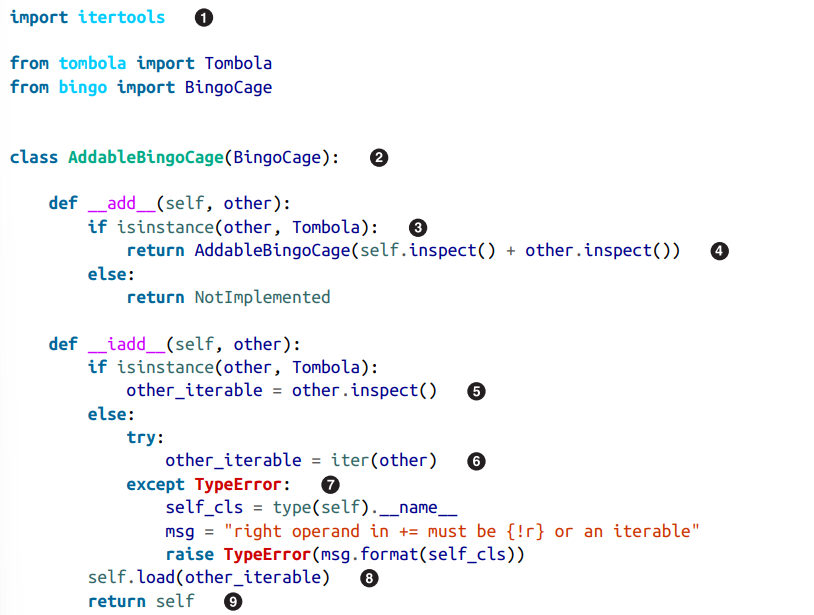
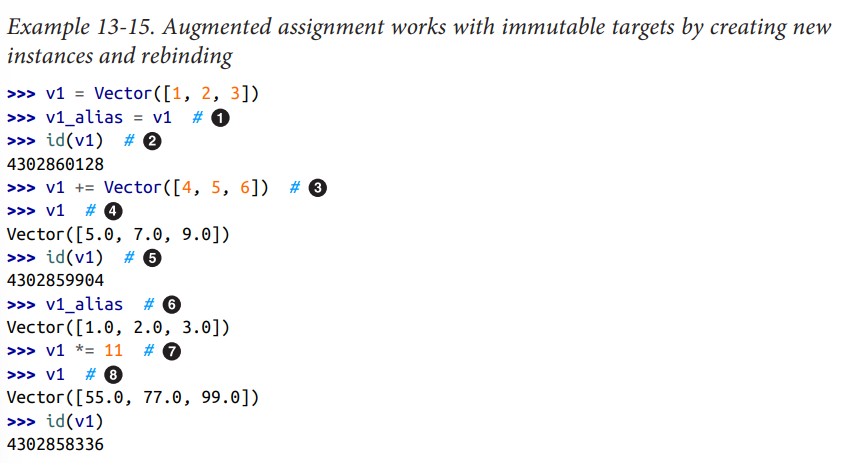
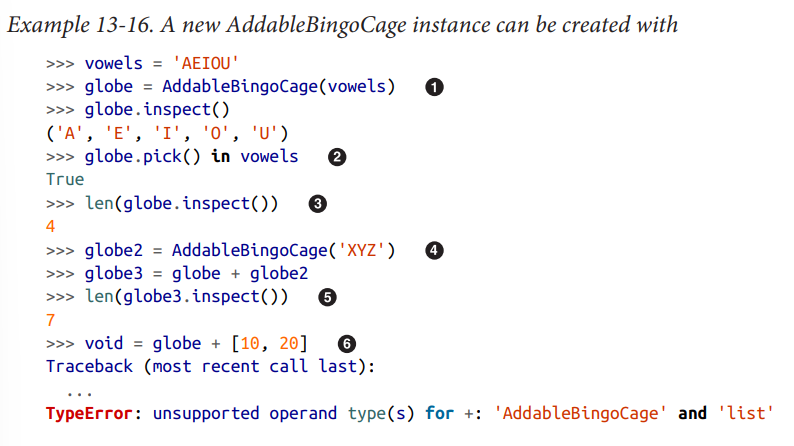
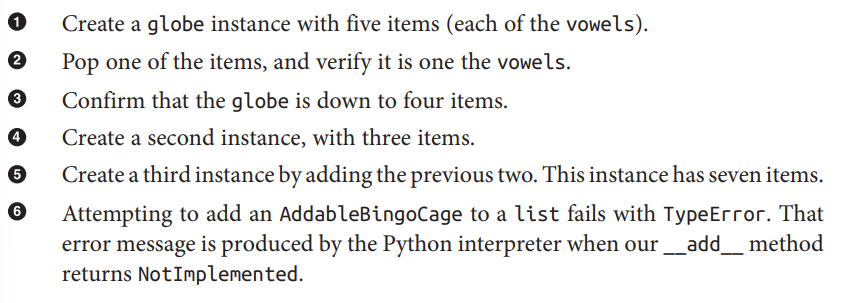
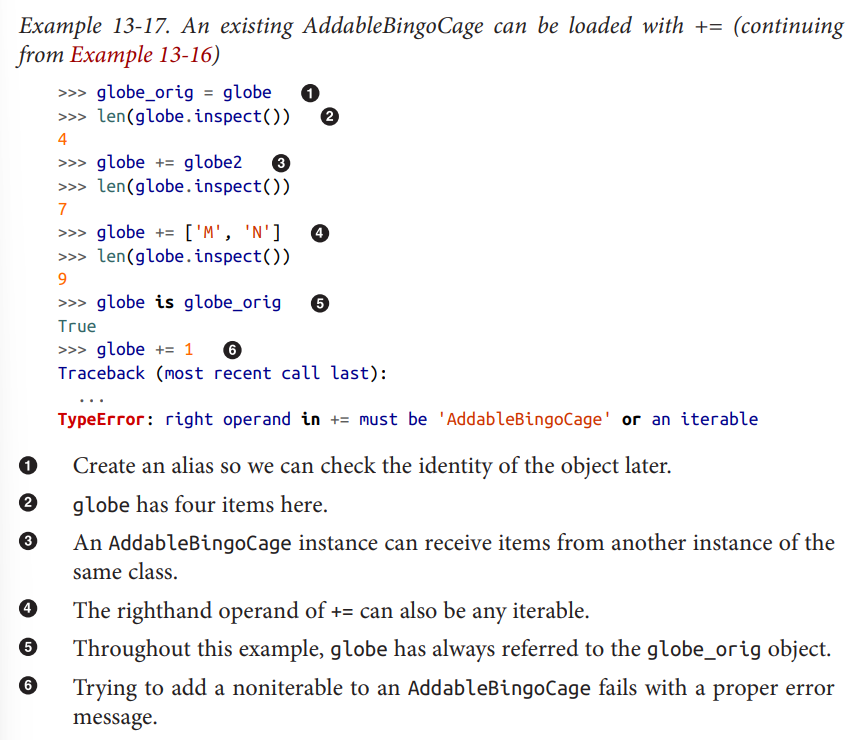